<a href="https://colab.research.google.com/github/Sravya106/ML-DL/blob/main/Malaria_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, InputLayer, AveragePooling2D, BatchNormalization, MaxPool2D, Dense, Flatten, Input, Layer, Dropout
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, activations
from tensorflow.keras.regularizers import L2

**Data Preparation and Data Visualization**

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, shuffle_files= True, as_supervised=True, split=['train'])

In [ ]:
def split(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  length = len(dataset)
  train = dataset.take(int(TRAIN_RATIO*length))
  val_test = dataset.skip(int(TRAIN_RATIO*length))
  val = val_test.take(int(VAL_RATIO*length))
  test = val_test.skip(int(VAL_RATIO*length))
  return train, val, test

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO= 0.1
TEST_RATIO = 0.1

train_data, val_data, test_data = split(dataset[0], TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

print(list(test_data.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]


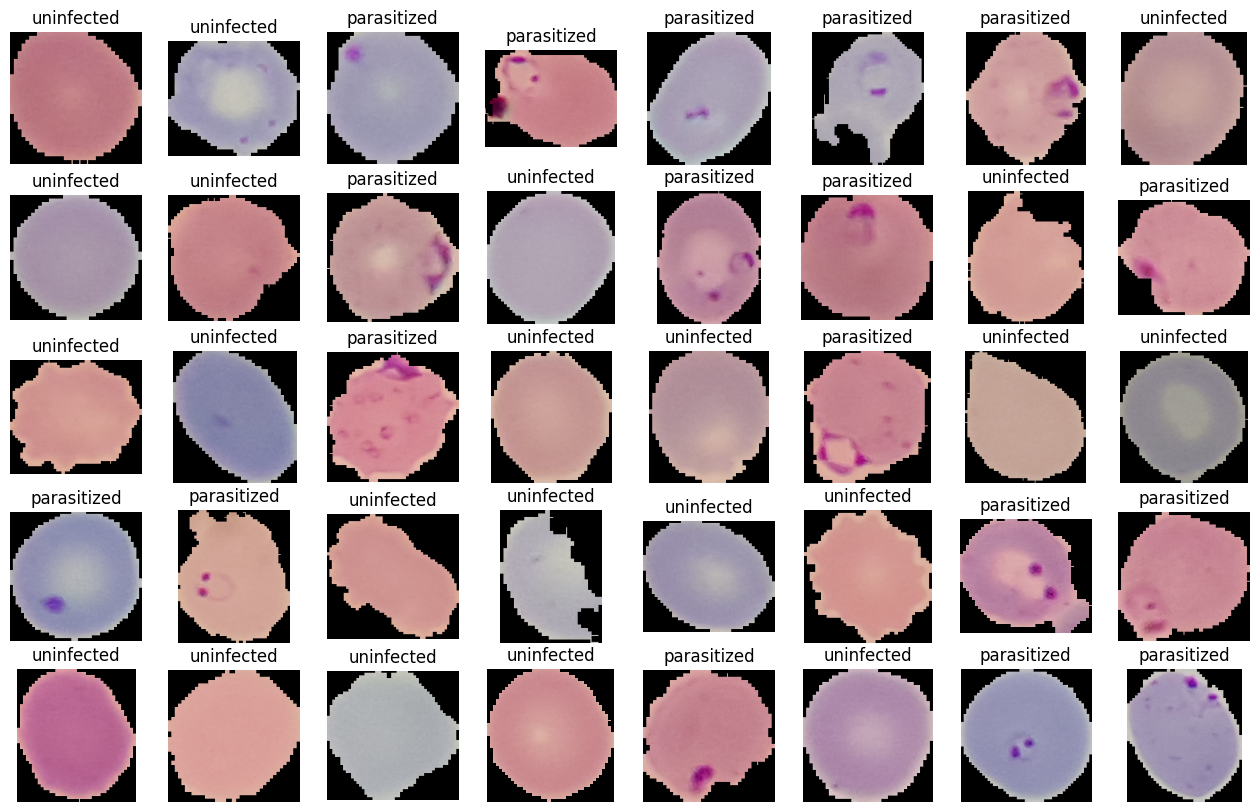

In [ ]:
plt.figure(figsize=(16, 10))
for i,(image, label) in enumerate(train_data.take(40)):
  ax = plt.subplot(5,8 , i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

**Data Preprocessing** *'resizing all the images to 224px'*

In [ ]:
IM_SIZE = 64
def resizing(image,label):
  return tf.image.resize(image,(IM_SIZE, IM_SIZE))/255.0, label

In [ ]:

train_data = train_data.map(resizing)
val_data = val_data.map(resizing)
test_data = test_data.map(resizing)


In [ ]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
train_data = (train_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

In [ ]:
val_data = (val_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

In [ ]:
test_data= (test_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

# **building model**  

#Sequential API

In [ ]:
from keras.src.layers.serialization import activation
lenet_model = Sequential([InputLayer(input_shape = (224,224,3)),
                             Conv2D(filters = 6, kernel_size = 3, activation= 'relu'),
                             BatchNormalization(),
                             AveragePooling2D(),

                             Conv2D(filters = 16, kernel_size = 3, activation = 'relu' ),
                             BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(),

                             tf.keras.layers.Flatten( ),

                             tf.keras.layers.Dense(100, activation = 'relu'),
                             BatchNormalization(),

                             tf.keras.layers.Dense(10, activation = 'relu'),
                             BatchNormalization(),

                             tf.keras.layers.Dense(2, activation = 'sigmoid'),


    ])
lenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 111, 111, 6)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Subclassing using Functional API
functional API enables you to create more complex models
Functional API con handle:
*   shared layers
*   multiple input and output







In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, activation, groups, padding):
    super(FeatureExtractor, self).__init__()

    self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, groups=groups, padding=padding)

    self.pool = MaxPool2D(pool_size=2, strides=2)

  def call(self, x, training):
    x = self.conv1(x)

    x = self.pool(x)

    return x

feature_sub_class1 = FeatureExtractor(32, 3, 'relu', 1, 'valid')
feature_sub_class2 = FeatureExtractor(64, 3, 'relu', 1, 'valid')

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_sub_class1 = FeatureExtractor(32, 3, 'relu', 1, 'same')
    self.feature_sub_class2 = FeatureExtractor(64, 3, 'relu', 1, 'valid')

    self.flatten = Flatten()

    self.dense1 = Dense(128, activation = 'relu')
    self.dense2 = Dense(10, activation = 'relu')
    self.dense3 = Dense(1, activation = 'softmax')

  def call(self, x, training = False):
    x = self.feature_sub_class1(x)
    x = self.feature_sub_class2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)

    return x

lenet_model = LenetModel()
lenet_model(tf.zeros([1,64,64,3]))


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [ ]:
func_input = Input(shape = (224, 224, 3), name = "Model")
x = feature_sub_class1(func_input)
x = feature_sub_class2(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
func_output = Dense(1, activation = 'sigmoid')(x)


In [ ]:
lenet_model = Model(func_input, func_output)

In [ ]:
lenet_model.summary()

Model: "lenet_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_30 (Feat  multiple                  896       
 ureExtractor)                                                   
                                                                 
 feature_extractor_31 (Feat  multiple                  18496     
 ureExtractor)                                                   
                                                                 
 flatten_13 (Flatten)        multiple                  0         
                                                                 
 dense_39 (Dense)            multiple                  1843328   
                                                                 
 dense_40 (Dense)            multiple                  1290      
                                                                 
 dense_41 (Dense)            multiple               

#Training


In [ ]:
lenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
               loss = tf.keras.losses.BinaryCrossentropy(),
               metrics = 'accuracy'
              )

In [ ]:
history = lenet_model.fit(train_data, validation_data = val_data, epochs= 15)

Epoch 1/15
689/689 [==============================] - 164s 236ms/step - loss: 0.6988 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.5038
Epoch 2/15
689/689 [==============================] - 163s 236ms/step - loss: 0.6934 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.5038
Epoch 3/15
689/689 [==============================] - 158s 229ms/step - loss: 0.6934 - accuracy: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.5067
Epoch 4/15
689/689 [==============================] - 163s 236ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5034
Epoch 5/15
689/689 [==============================] - 162s 235ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5067
Epoch 6/15
689/689 [==============================] - 161s 234ms/step - loss: 0.6934 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.5053
Epoch 7/15
689/689 [==============================] - 161s 234ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6935 -

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: ignored

# **Model Evaluation and Testing**

In [ ]:
test_data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# val_data

In [ ]:
lenet_model.evaluate(test_data)

87/87 [==============================] - 46s 381ms/step - loss: 0.6932 - accuracy: 0.4962


[0.6932435631752014, 0.49619150161743164]

In [ ]:
y_true = test_data
y_pred = lenet_model.predict(test_data)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)


87/87 [==============================] - 66s 454ms/step


In [ ]:
lenet_model.predict(test_data.take(1))[0][0]

1/1 [==============================] - 13s 13s/step


0.99999994

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('p')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_data.take(1))[0][0])


1/1 [==============================] - 13s 13s/step


'U'

This model may not be as accurate because the no.of epoches is set to 5 for saving time, in practiece no.of epoch is set 100 for better accuracy.

1/1 [==============================] - 0s 329ms/step


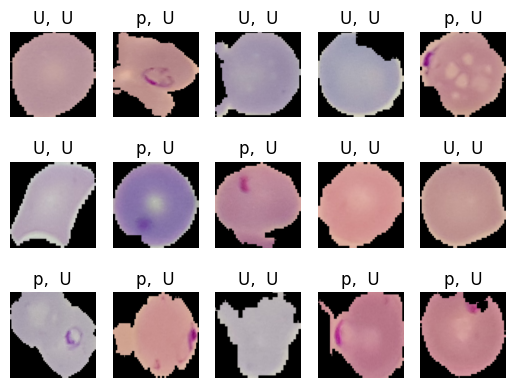

In [ ]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(test_data.take(15)):
    ax = plt.subplot(3, 5, i + 1)  # Use a 1x5 grid
    plt.imshow(image[0].numpy())  # Convert the tensor to a NumPy array
    true_label = label.numpy()[0]
    predicted_label = lenet_model.predict(image)[0][0]
    plt.title(f"{parasite_or_not(true_label)},  {parasite_or_not(predicted_label)}")
    plt.axis('off')

plt.show()

# Confusion Matrics

In [ ]:
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
labels = []
inp = []
# for t in test_dataset:
#   print(t)
#   break
for x,y in test_data.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

In [ ]:
print(np.array(lables).shape)

(87,)


<ipython-input-107-adec27746d09>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(lables).shape)
